In [1]:
!cd ..
!pwd

/content


In [2]:
%%capture
!rm -r GETAM
!git clone https://github.com/Hammad-Mir/GETAM

In [3]:
%%capture
! pip install timm

In [4]:
%%capture
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

In [5]:
! pwd

/content


In [6]:
import os
import cv2
import tarfile
import numpy as np
import pandas as pd
from math import ceil
from time import time
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
#from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [7]:
os.chdir(f'./GETAM')

In [8]:
import myTool as mytool
#from DenseEnergyLoss import DenseEnergyLoss
from DPT.DPT import DPT, DPTSegmentationModel
from tool import pyutils, imutils, torchutils
from myTool import compute_joint_loss, compute_seg_label_3, validation

In [9]:
np.random.seed(42)
torch.manual_seed(42)

# Setting up GPU

In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# Test images


In [11]:
test_image_path_1  = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Viz_Test_Images/436219-7159-48057-[1, 0, 0].png'
#test_image_path_2  = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Viz_Test_Images/439448-38035-50808-[0, 1, 0].png'
valid_image_path   = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Viz_Test_Images/00.png'
valid_mask_path    = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Viz_Test_Images/00_1.png'

In [12]:
test_image_1  = cv2.resize(cv2.imread(test_image_path_1), (224, 224))
#test_image_2  = cv2.resize(cv2.imread(test_image_path_2), (224, 224))
valid_image = cv2.resize(cv2.imread(valid_image_path), (224, 224))
valid_mask  = cv2.resize(cv2.imread(valid_mask_path), (224, 224))

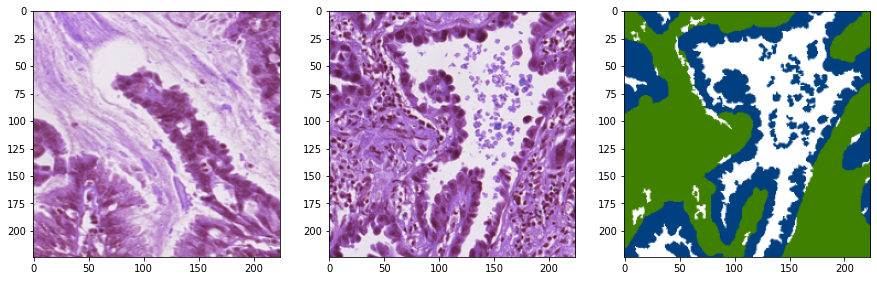

In [71]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(test_image_1)

ax = fig.add_subplot(1, 3, 2)
plt.imshow(valid_image)

ax = fig.add_subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [14]:
def preprocess_image(img: np.ndarray, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], resized = (224, 224)) -> torch.Tensor:
  
  preprocessing = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize(resized),
                                      transforms.Normalize(mean, std),
                                      ])
  return preprocessing(img.copy()).unsqueeze(0)

In [15]:
def reshape_transform(tensor, height=14, width=14):
  result = tensor[:, 1 :  , :].reshape(tensor.size(0),
                                       height, width, tensor.size(2))
  
  # Bring the channels to the first dimension,
  # like in CNNs.
  result = result.transpose(2, 3).transpose(1, 2)
  return result

In [108]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [72]:
valid_image_tensor = preprocess_image(valid_image)
test_image_1_tensor = preprocess_image(test_image_1)

In [33]:
valid_image_tensor.shape

torch.Size([1, 3, 224, 224])

# Creating the Model

In [18]:
GETAM_model = DPTSegmentationModel(num_classes=3, backbone_name='vitb16_224', pretrained = False).to(device)
GETAM_model.load_state_dict(torch.load(f='/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_GETAM.pth',
                                       map_location=torch.device(device)))

cur_backbone: vitb16_224


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


<All keys matched successfully>

In [42]:
GETAM_model.forward_cls(torch.randn(10, 3, 224, 224).to(device)).size()[-1]

3

In [ ]:
#torchsummary.summary(GETAM_model, (3, 224, 224))

# Generating Image CAMs

In [151]:
cam_matrix = torch.zeros((1, 3, 224, 224))
seg_label = np.zeros((224, 224))
label = np.array([1, 1, 0], dtype='float32')
output = GETAM_model.forward_cls(valid_image_tensor.to(device))

In [152]:
output

tensor([[ 3.4562,  3.5487, -5.1686]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [153]:
for class_index in range(3):
  if label[class_index] > 1e-5:
    one_hot = np.zeros((1, 3), dtype=np.float32)
    one_hot[0, class_index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.to(device) * output)

    GETAM_model.zero_grad()
    one_hot.backward(retain_graph=True)
    cam, _, _ = GETAM_model.generate_cam_2(0, start_layer=6)

    cam = cam.reshape(int(224 //16), int(224 //16))

    cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), (224, 224), mode='bilinear', align_corners=True)
    cam_matrix[0, class_index,:,:] = cam

In [154]:
cam_matrix.shape

torch.Size([1, 3, 224, 224])

In [155]:
valid_cam = cam_matrix.cpu().detach().numpy().squeeze(0)

In [185]:
valid_cam[0, 100, 75]*255

0.028218853658472653

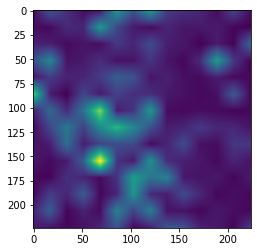

In [222]:
plt.imshow(np.uint8(1000000*valid_cam[0]))

In [259]:
np.uint8(1000000*valid_cam[0])[100, 75]

110

In [195]:
(valid_image/255)[100, 75, 0]

0.7254901960784313

In [265]:
val = (valid_image) + (np.uint8(1000000*valid_cam[0]).reshape((224, 224, 1)))
val = (val/np.max(val))

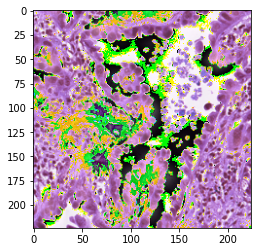

In [267]:
plt.imshow(val)

In [268]:
heatmap = cv2.applyColorMap(np.uint8(1000000*valid_cam[0]), cv2.COLORMAP_JET)

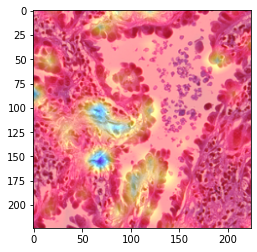

In [271]:
plt.imshow(cv2.addWeighted(heatmap, 0.5, valid_image, 0.7, 0))